# Import packages

import useful packages for experiments

In [1]:
import os
import argparse
import logging

import torch
from torch.optim.lr_scheduler import StepLR
import torchtext

from trainer.supervised_trainer import SupervisedTrainer
from models.encoderRNN import EncoderRNN
from models.decoderRNN import DecoderRNN
from models.seq2seq import Seq2seq
from loss.loss import Perplexity
from optim.optim import Optimizer
from dataset import fields
from evaluator.predictor import Predictor

import matplotlib.pyplot as plt

/home/hyeontae/hyeontae/venv/lib/python3.5/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='elementwise_mean' instead.
  warnings.warn(warning.format(ret))


# Data load

In [2]:
train_path = "data/grammar_data_train.txt"
dev_path = "data/grammar_data_test.txt"
log_level = 'info'

# Log format

In [3]:
LOG_FORMAT = '%(asctime)s %(levelname)-6s %(message)s'
logging.basicConfig(format=LOG_FORMAT, level=getattr(logging, log_level.upper()))

# Prepare dataset

In [4]:
src = fields.SourceField()
tgt = fields.TargetField()
max_len = 100
def len_filter(example):
    return len(example.src) <= max_len and len(example.tgt) <= max_len
train = torchtext.data.TabularDataset(
    path=train_path, format='tsv',
    fields=[('src', src), ('tgt', tgt)],
    filter_pred=len_filter
)
dev = torchtext.data.TabularDataset(
    path=dev_path, format='tsv',
    fields=[('src', src), ('tgt', tgt)],
    filter_pred=len_filter
)
src.build_vocab(train)
tgt.build_vocab(train)
input_vocab = src.vocab
output_vocab = tgt.vocab

# Prepare loss

In [5]:
weight = torch.ones(len(tgt.vocab))
pad = tgt.vocab.stoi[tgt.pad_token]
loss = Perplexity(weight, pad)
if torch.cuda.is_available():
    loss.cuda()

/home/hyeontae/hyeontae/venv/lib/python3.5/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


# Variable definition

In [6]:
seq2seq = None
optimizer = None

hidden_sizes = list(range(4, 50, 4))
print(hidden_sizes)
error_rate = []
accuracy = []
losses = []

[4, 8, 12, 16, 20, 24, 28, 32, 36, 40, 44, 48]


# Initialize model

In [7]:
for i in hidden_sizes:
    print("Hidden size is %d" % i)
    hidden_size = i
    bidirectional = True
    encoder = EncoderRNN(len(src.vocab), max_len, hidden_size,
                        bidirectional=bidirectional, variable_lengths=True)
    decoder = DecoderRNN(len(tgt.vocab), max_len, hidden_size * 2 if bidirectional else hidden_size,
                        dropout_p=0.2, use_attention=False, bidirectional=bidirectional,
                        eos_id=tgt.eos_id, sos_id=tgt.sos_id)
    seq2seq = Seq2seq(encoder, decoder)
    if torch.cuda.is_available():
        seq2seq.cuda()

    for param in seq2seq.parameters():
        param.data.uniform_(-0.08, 0.08)

    # train
    t = SupervisedTrainer(loss=loss, batch_size=32,
                        checkpoint_every=50,
                        print_every=100)

    seq2seq, ave_loss, character_accuracy = t.train(seq2seq, train,
                                                    num_epochs=10, dev_data=dev,
                                                    optimizer=optimizer,
                                                    teacher_forcing_ratio=0.5)

    losses.append(ave_loss/100)
    error_rate.append(1 - character_accuracy)
    accuracy.append(character_accuracy)

/home/hyeontae/hyeontae/venv/lib/python3.5/site-packages/torch/nn/modules/rnn.py:38: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))
2019-01-21 11:01:09,789 INFO   Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
), Scheduler: None


Hidden size is 4


2019-01-21 11:01:49,037 INFO   Finished epoch 1: Train loss: 15.1436, Dev loss: 33.6574, Accuracy(Character): 0.1936, Accuracy(Word): 0.0000
2019-01-21 11:02:28,037 INFO   Finished epoch 2: Train loss: 10.3801, Dev loss: 14.9307, Accuracy(Character): 0.1646, Accuracy(Word): 0.0000
2019-01-21 11:03:06,671 INFO   Finished epoch 3: Train loss: 7.0178, Dev loss: 15.4963, Accuracy(Character): 0.2516, Accuracy(Word): 0.0342
2019-01-21 11:03:45,920 INFO   Finished epoch 4: Train loss: 7.1099, Dev loss: 22.9810, Accuracy(Character): 0.2622, Accuracy(Word): 0.0342
2019-01-21 11:04:26,137 INFO   Finished epoch 5: Train loss: 6.8619, Dev loss: 22.0369, Accuracy(Character): 0.2270, Accuracy(Word): 0.0342
2019-01-21 11:05:04,601 INFO   Finished epoch 6: Train loss: 7.9162, Dev loss: 19.0622, Accuracy(Character): 0.3887, Accuracy(Word): 0.0342
2019-01-21 11:05:44,510 INFO   Finished epoch 7: Train loss: 6.7891, Dev loss: 14.9969, Accuracy(Character): 0.3938, Accuracy(Word): 0.0342
2019-01-21 11:06:2

Hidden size is 8


2019-01-21 11:08:21,448 INFO   Finished epoch 1: Train loss: 11.5475, Dev loss: 14.2004, Accuracy(Character): 0.1696, Accuracy(Word): 0.0000
2019-01-21 11:09:00,353 INFO   Finished epoch 2: Train loss: 6.8042, Dev loss: 17.7285, Accuracy(Character): 0.3345, Accuracy(Word): 0.0342
2019-01-21 11:09:39,624 INFO   Finished epoch 3: Train loss: 6.0286, Dev loss: 13.0643, Accuracy(Character): 0.4043, Accuracy(Word): 0.0342
2019-01-21 11:10:18,355 INFO   Finished epoch 4: Train loss: 4.4098, Dev loss: 11.5364, Accuracy(Character): 0.4350, Accuracy(Word): 0.0342
2019-01-21 11:10:56,940 INFO   Finished epoch 5: Train loss: 4.4239, Dev loss: 14.7948, Accuracy(Character): 0.4409, Accuracy(Word): 0.0342
2019-01-21 11:11:36,155 INFO   Finished epoch 6: Train loss: 4.6063, Dev loss: 11.1304, Accuracy(Character): 0.4483, Accuracy(Word): 0.0626
2019-01-21 11:12:14,863 INFO   Finished epoch 7: Train loss: 3.0877, Dev loss: 7.5584, Accuracy(Character): 0.4681, Accuracy(Word): 0.0626
2019-01-21 11:12:53,

Hidden size is 12


2019-01-21 11:14:50,565 INFO   Finished epoch 1: Train loss: 11.2265, Dev loss: 22.6440, Accuracy(Character): 0.2173, Accuracy(Word): 0.0342
2019-01-21 11:15:29,912 INFO   Finished epoch 2: Train loss: 8.6366, Dev loss: 18.3698, Accuracy(Character): 0.4088, Accuracy(Word): 0.0342
2019-01-21 11:16:08,930 INFO   Finished epoch 3: Train loss: 4.4106, Dev loss: 11.2143, Accuracy(Character): 0.4406, Accuracy(Word): 0.0342
2019-01-21 11:16:47,144 INFO   Finished epoch 4: Train loss: 3.9971, Dev loss: 10.5342, Accuracy(Character): 0.4722, Accuracy(Word): 0.0626
2019-01-21 11:17:27,012 INFO   Finished epoch 5: Train loss: 3.9858, Dev loss: 11.1053, Accuracy(Character): 0.5074, Accuracy(Word): 0.0627
2019-01-21 11:18:06,545 INFO   Finished epoch 6: Train loss: 3.2478, Dev loss: 5.8784, Accuracy(Character): 0.5143, Accuracy(Word): 0.0867
2019-01-21 11:18:45,761 INFO   Finished epoch 7: Train loss: 2.5102, Dev loss: 5.5444, Accuracy(Character): 0.5126, Accuracy(Word): 0.0867
2019-01-21 11:19:25,7

Hidden size is 16


2019-01-21 11:21:24,885 INFO   Finished epoch 1: Train loss: 9.1331, Dev loss: 10.5787, Accuracy(Character): 0.4219, Accuracy(Word): 0.0342
2019-01-21 11:22:04,014 INFO   Finished epoch 2: Train loss: 3.5847, Dev loss: 6.3359, Accuracy(Character): 0.4733, Accuracy(Word): 0.0626
2019-01-21 11:22:42,837 INFO   Finished epoch 3: Train loss: 3.0992, Dev loss: 8.5769, Accuracy(Character): 0.4997, Accuracy(Word): 0.0626
2019-01-21 11:23:22,589 INFO   Finished epoch 4: Train loss: 2.5350, Dev loss: 4.9884, Accuracy(Character): 0.5133, Accuracy(Word): 0.0626
2019-01-21 11:24:02,258 INFO   Finished epoch 5: Train loss: 2.8871, Dev loss: 7.1519, Accuracy(Character): 0.4941, Accuracy(Word): 0.0626
2019-01-21 11:24:40,983 INFO   Finished epoch 6: Train loss: 3.0032, Dev loss: 8.0850, Accuracy(Character): 0.5143, Accuracy(Word): 0.0626
2019-01-21 11:25:20,495 INFO   Finished epoch 7: Train loss: 3.1516, Dev loss: 5.3917, Accuracy(Character): 0.5414, Accuracy(Word): 0.0867
2019-01-21 11:25:59,274 IN

Hidden size is 20


2019-01-21 11:27:57,529 INFO   Finished epoch 1: Train loss: 8.4148, Dev loss: 12.3510, Accuracy(Character): 0.4496, Accuracy(Word): 0.0342
2019-01-21 11:28:37,242 INFO   Finished epoch 2: Train loss: 4.6447, Dev loss: 14.5756, Accuracy(Character): 0.4437, Accuracy(Word): 0.0626
2019-01-21 11:29:16,319 INFO   Finished epoch 3: Train loss: 3.7691, Dev loss: 5.4548, Accuracy(Character): 0.5174, Accuracy(Word): 0.0626
2019-01-21 11:29:55,870 INFO   Finished epoch 4: Train loss: 2.7273, Dev loss: 5.2791, Accuracy(Character): 0.5088, Accuracy(Word): 0.0626
2019-01-21 11:30:35,000 INFO   Finished epoch 5: Train loss: 2.0156, Dev loss: 4.3431, Accuracy(Character): 0.5647, Accuracy(Word): 0.0867
2019-01-21 11:31:14,293 INFO   Finished epoch 6: Train loss: 2.1574, Dev loss: 5.1774, Accuracy(Character): 0.5544, Accuracy(Word): 0.0867
2019-01-21 11:31:53,228 INFO   Finished epoch 7: Train loss: 2.2547, Dev loss: 9.5328, Accuracy(Character): 0.5435, Accuracy(Word): 0.0867
2019-01-21 11:32:32,833 I

Hidden size is 24


2019-01-21 11:34:29,499 INFO   Finished epoch 1: Train loss: 8.2121, Dev loss: 8.9249, Accuracy(Character): 0.4887, Accuracy(Word): 0.0626
2019-01-21 11:35:08,756 INFO   Finished epoch 2: Train loss: 3.6381, Dev loss: 8.7998, Accuracy(Character): 0.4661, Accuracy(Word): 0.0626
2019-01-21 11:35:47,374 INFO   Finished epoch 3: Train loss: 2.8781, Dev loss: 7.8410, Accuracy(Character): 0.5114, Accuracy(Word): 0.0626
2019-01-21 11:36:26,690 INFO   Finished epoch 4: Train loss: 2.6825, Dev loss: 5.1313, Accuracy(Character): 0.5497, Accuracy(Word): 0.0867
2019-01-21 11:37:06,524 INFO   Finished epoch 5: Train loss: 2.4708, Dev loss: 4.9005, Accuracy(Character): 0.5744, Accuracy(Word): 0.0867
2019-01-21 11:37:46,060 INFO   Finished epoch 6: Train loss: 2.1981, Dev loss: 6.4342, Accuracy(Character): 0.5660, Accuracy(Word): 0.0868
2019-01-21 11:38:26,353 INFO   Finished epoch 7: Train loss: 2.0174, Dev loss: 4.0489, Accuracy(Character): 0.6095, Accuracy(Word): 0.1078
2019-01-21 11:39:06,356 INF

Hidden size is 28


2019-01-21 11:41:03,272 INFO   Finished epoch 1: Train loss: 7.2807, Dev loss: 9.7909, Accuracy(Character): 0.4846, Accuracy(Word): 0.0626
2019-01-21 11:41:42,930 INFO   Finished epoch 2: Train loss: 3.1700, Dev loss: 11.2233, Accuracy(Character): 0.4814, Accuracy(Word): 0.0626
2019-01-21 11:42:22,044 INFO   Finished epoch 3: Train loss: 2.4929, Dev loss: 5.4878, Accuracy(Character): 0.5216, Accuracy(Word): 0.0626
2019-01-21 11:43:01,328 INFO   Finished epoch 4: Train loss: 2.5421, Dev loss: 5.3415, Accuracy(Character): 0.5234, Accuracy(Word): 0.0626
2019-01-21 11:43:40,479 INFO   Finished epoch 5: Train loss: 2.3180, Dev loss: 4.3229, Accuracy(Character): 0.5610, Accuracy(Word): 0.0867
2019-01-21 11:44:19,106 INFO   Finished epoch 6: Train loss: 2.4182, Dev loss: 7.6452, Accuracy(Character): 0.5454, Accuracy(Word): 0.0867
2019-01-21 11:44:58,515 INFO   Finished epoch 7: Train loss: 2.1089, Dev loss: 8.6477, Accuracy(Character): 0.5779, Accuracy(Word): 0.0867
2019-01-21 11:45:37,855 IN

Hidden size is 32


2019-01-21 11:47:34,965 INFO   Finished epoch 1: Train loss: 6.4397, Dev loss: 8.1390, Accuracy(Character): 0.4393, Accuracy(Word): 0.0626
2019-01-21 11:48:14,400 INFO   Finished epoch 2: Train loss: 2.8437, Dev loss: 8.7625, Accuracy(Character): 0.5154, Accuracy(Word): 0.0626
2019-01-21 11:48:53,527 INFO   Finished epoch 3: Train loss: 2.4207, Dev loss: 13.3933, Accuracy(Character): 0.5348, Accuracy(Word): 0.0867
2019-01-21 11:49:33,408 INFO   Finished epoch 4: Train loss: 2.4092, Dev loss: 3.9883, Accuracy(Character): 0.5933, Accuracy(Word): 0.0867
2019-01-21 11:50:12,196 INFO   Finished epoch 5: Train loss: 2.1189, Dev loss: 5.9682, Accuracy(Character): 0.5831, Accuracy(Word): 0.1076
2019-01-21 11:50:51,348 INFO   Finished epoch 6: Train loss: 1.9754, Dev loss: 3.9977, Accuracy(Character): 0.6167, Accuracy(Word): 0.1077
2019-01-21 11:51:30,873 INFO   Finished epoch 7: Train loss: 1.9779, Dev loss: 3.7084, Accuracy(Character): 0.6272, Accuracy(Word): 0.1077
2019-01-21 11:52:09,718 IN

Hidden size is 36


2019-01-21 11:54:08,009 INFO   Finished epoch 1: Train loss: 6.2334, Dev loss: 6.9403, Accuracy(Character): 0.5032, Accuracy(Word): 0.0626
2019-01-21 11:54:47,512 INFO   Finished epoch 2: Train loss: 2.6657, Dev loss: 4.7815, Accuracy(Character): 0.5532, Accuracy(Word): 0.0626
2019-01-21 11:55:27,146 INFO   Finished epoch 3: Train loss: 2.3404, Dev loss: 6.1890, Accuracy(Character): 0.5754, Accuracy(Word): 0.0867
2019-01-21 11:56:06,336 INFO   Finished epoch 4: Train loss: 2.1486, Dev loss: 4.6310, Accuracy(Character): 0.6113, Accuracy(Word): 0.0867
2019-01-21 11:56:45,784 INFO   Finished epoch 5: Train loss: 1.9852, Dev loss: 5.2595, Accuracy(Character): 0.6130, Accuracy(Word): 0.1077
2019-01-21 11:57:25,544 INFO   Finished epoch 6: Train loss: 1.8676, Dev loss: 3.6414, Accuracy(Character): 0.6440, Accuracy(Word): 0.1078
2019-01-21 11:58:04,549 INFO   Finished epoch 7: Train loss: 1.7102, Dev loss: 4.5963, Accuracy(Character): 0.6401, Accuracy(Word): 0.1077
2019-01-21 11:58:44,211 INF

Hidden size is 40


2019-01-21 12:00:42,173 INFO   Finished epoch 1: Train loss: 6.0661, Dev loss: 6.1862, Accuracy(Character): 0.5320, Accuracy(Word): 0.0626
2019-01-21 12:01:21,523 INFO   Finished epoch 2: Train loss: 2.6165, Dev loss: 6.8971, Accuracy(Character): 0.5478, Accuracy(Word): 0.0626
2019-01-21 12:02:01,072 INFO   Finished epoch 3: Train loss: 2.1787, Dev loss: 4.0439, Accuracy(Character): 0.6102, Accuracy(Word): 0.0867
2019-01-21 12:02:41,271 INFO   Finished epoch 4: Train loss: 1.8340, Dev loss: 4.1035, Accuracy(Character): 0.6233, Accuracy(Word): 0.0872
2019-01-21 12:03:20,462 INFO   Finished epoch 5: Train loss: 1.7329, Dev loss: 4.5991, Accuracy(Character): 0.6341, Accuracy(Word): 0.1081
2019-01-21 12:03:59,518 INFO   Finished epoch 6: Train loss: 1.7876, Dev loss: 4.1157, Accuracy(Character): 0.6710, Accuracy(Word): 0.1261
2019-01-21 12:04:39,692 INFO   Finished epoch 7: Train loss: 1.7041, Dev loss: 3.8447, Accuracy(Character): 0.6686, Accuracy(Word): 0.1261
2019-01-21 12:05:19,113 INF

Hidden size is 44


2019-01-21 12:07:18,337 INFO   Finished epoch 1: Train loss: 5.7032, Dev loss: 5.6630, Accuracy(Character): 0.5255, Accuracy(Word): 0.0626
2019-01-21 12:07:57,828 INFO   Finished epoch 2: Train loss: 2.3377, Dev loss: 13.6677, Accuracy(Character): 0.5338, Accuracy(Word): 0.0867
2019-01-21 12:08:38,260 INFO   Finished epoch 3: Train loss: 2.1915, Dev loss: 4.8803, Accuracy(Character): 0.6247, Accuracy(Word): 0.1076
2019-01-21 12:09:17,869 INFO   Finished epoch 4: Train loss: 1.8555, Dev loss: 3.6000, Accuracy(Character): 0.6521, Accuracy(Word): 0.1076
2019-01-21 12:09:57,140 INFO   Finished epoch 5: Train loss: 1.6893, Dev loss: 4.0031, Accuracy(Character): 0.6670, Accuracy(Word): 0.1077
2019-01-21 12:10:36,032 INFO   Finished epoch 6: Train loss: 1.7029, Dev loss: 3.8932, Accuracy(Character): 0.6780, Accuracy(Word): 0.1260
2019-01-21 12:11:15,762 INFO   Finished epoch 7: Train loss: 1.5904, Dev loss: 3.5183, Accuracy(Character): 0.6844, Accuracy(Word): 0.1260
2019-01-21 12:11:55,371 IN

Hidden size is 48


2019-01-21 12:13:53,102 INFO   Finished epoch 1: Train loss: 5.8506, Dev loss: 9.6975, Accuracy(Character): 0.5034, Accuracy(Word): 0.0626
2019-01-21 12:14:31,940 INFO   Finished epoch 2: Train loss: 2.6462, Dev loss: 4.6111, Accuracy(Character): 0.5642, Accuracy(Word): 0.0867
2019-01-21 12:15:11,629 INFO   Finished epoch 3: Train loss: 2.1823, Dev loss: 5.1565, Accuracy(Character): 0.6041, Accuracy(Word): 0.0867
2019-01-21 12:15:51,026 INFO   Finished epoch 4: Train loss: 1.9417, Dev loss: 3.7324, Accuracy(Character): 0.6276, Accuracy(Word): 0.1076
2019-01-21 12:16:30,646 INFO   Finished epoch 5: Train loss: 1.7274, Dev loss: 4.5743, Accuracy(Character): 0.6307, Accuracy(Word): 0.1076
2019-01-21 12:17:09,921 INFO   Finished epoch 6: Train loss: 1.6604, Dev loss: 3.6718, Accuracy(Character): 0.6555, Accuracy(Word): 0.1076
2019-01-21 12:17:49,221 INFO   Finished epoch 7: Train loss: 1.6210, Dev loss: 3.6171, Accuracy(Character): 0.6578, Accuracy(Word): 0.1179
2019-01-21 12:18:29,194 INF

# Experimental results

- units to loss

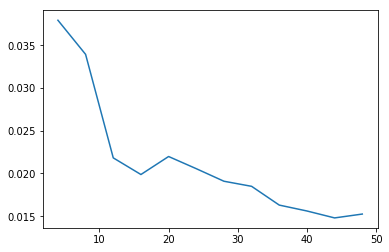

In [8]:
plt.plot(hidden_sizes, losses)
plt.savefig('units_to_loss.png')

- units to error rate

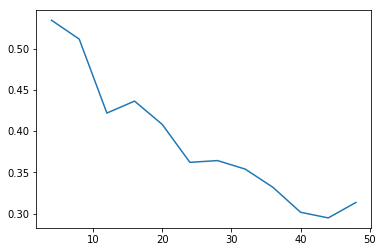

In [10]:
plt.clf()
plt.plot(hidden_sizes, error_rate)
plt.savefig('units_to_error_rate.png')

- units to accuracy

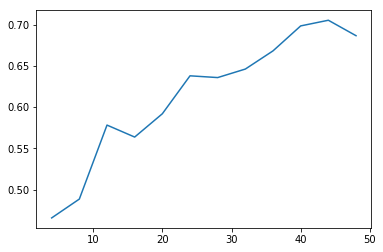

In [11]:
plt.clf()
plt.plot(hidden_sizes, accuracy)
plt.savefig('units_to_accuracy.png')

- save last model

In [11]:
torch.save(seq2seq.state_dict(), 'log/model_save.pth')